In [1]:
import pandas as pd,numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def percentage(df,df1,item):
    """Prints out number of samples and percent of total"""
    """df is the base and df1 is specific df we are interested in and item is the column we are trying to look at"""

    all_loans = df[item].value_counts().sort_index()
    bad_loans = pd.DataFrame(df1[item].value_counts().sort_index() / all_loans * 100)
    n_percent = pd.concat([all_loans,bad_loans],axis=1)
    n_percent.columns = ['n_samples', 'percent']
    n_percent.fillna(0,inplace=True)
    print(n_percent)
    
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y    

In [3]:
df = pd.read_csv('loan_data_core.csv')
df.info()

C:\Users\leero\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507640 entries, 0 to 2507639
Columns: 151 entries, id to settlement_term
dtypes: float64(112), int64(1), object(38)
memory usage: 2.8+ GB


In [4]:
#conversions
df.issue_d = pd.to_datetime(df.issue_d,format='%b-%y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line,format='%b-%y')
df['length_of_cr'] = df.issue_d - df.earliest_cr_line
df.length_of_cr = df.length_of_cr.dt.days.astype(int)/365

#good loans = 1
df.loan_status = df.loan_status.apply(lambda loan_status: 1 if loan_status != 'Charged Off' else 0)
df.term = df.term.apply(lambda months: int(months[1:3]))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507640 entries, 0 to 2507639
Columns: 152 entries, id to length_of_cr
dtypes: datetime64[ns](2), float64(113), int64(3), object(34)
memory usage: 2.8+ GB


In [5]:
#random things of interest

df['difference_inv'] = (df.funded_amnt_inv - df.funded_amnt) / df.funded_amnt_inv
df['difference_asked'] = (df.loan_amnt - df.funded_amnt) / df.loan_amnt

df['diff_fico_high'] = df.fico_range_high - df. sec_app_fico_range_high
df['diff_fico_low'] = df.fico_range_low - df. sec_app_fico_range_low

In [6]:
df.int_rate = df.int_rate.apply(lambda interest: interest[0:len(interest)-1]).astype('float64')

In [7]:
df_bad = df.loc[df.loan_status==0]
df_pass = df.loc[df.loan_status==1]

#the fail rate
print(len(df_bad)/len(df))
print(len(df_bad),len(df_pass))

print('Passing rates')
print('By rows: ',len(df_pass)/len(df))
print('By loan amount: ',np.average(df.loan_status,weights=df.loan_amnt))
print('By interest rate: ',np.average(df.loan_status,weights=df.int_rate))

0.19864095324687756
498120 2009520
Passing rates
By rows:  0.8013590467531224
By loan amount:  0.7862432609493137
By interest rate:  0.7646819714537525


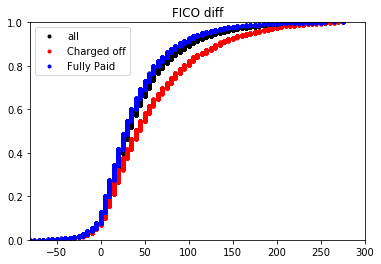

count    23510.000000
mean        41.753977
std         44.937476
min        -80.000000
25%         10.000000
50%         30.000000
75%         60.000000
max        275.000000
Name: diff_fico_high, dtype: float64
count    5032.000000
mean       56.096979
std        55.197095
min       -60.000000
25%        15.000000
50%        40.000000
75%        85.000000
max       275.000000
Name: diff_fico_high, dtype: float64
count    18478.000000
mean        37.848036
std         40.846952
min        -80.000000
25%         10.000000
50%         30.000000
75%         55.000000
max        275.000000
Name: diff_fico_high, dtype: float64


In [8]:
df_x,df_y = ecdf(df.diff_fico_high.dropna())
df_bad_x,df_bad_y = ecdf(df.loc[df.loan_status==0].diff_fico_high.dropna())
df_pass_x,df_pass_y = ecdf(df.loc[df.loan_status==1].diff_fico_high.dropna())

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([-80, 300, 0, 1])
plt.title('FICO diff')
plt.legend(loc='best')
plt.show()

print(df.diff_fico_high.describe())
print(df.loc[df.loan_status==0].diff_fico_high.describe())
print(df.loc[df.loan_status==1].diff_fico_high.describe())

FICO scores can vary widely between partners

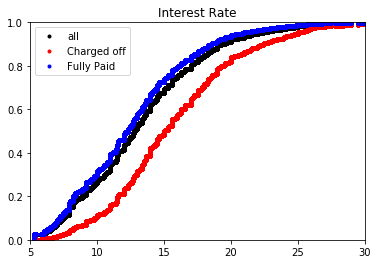

count    2.507640e+06
mean     1.324848e+01
std      4.733669e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.279000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64
count    498120.000000
mean         15.694675
std           4.858772
min           5.310000
25%          12.290000
50%          15.050000
75%          18.550000
max          30.990000
Name: int_rate, dtype: float64
count    2.009520e+06
mean     1.264211e+01
std      4.501023e+00
min      5.310000e+00
25%      9.170000e+00
50%      1.229000e+01
75%      1.531000e+01
max      3.099000e+01
Name: int_rate, dtype: float64


In [9]:
df_x,df_y = ecdf(df.int_rate)
df_bad_x,df_bad_y = ecdf(df.loc[df.loan_status==0].int_rate)
df_pass_x,df_pass_y = ecdf(df.loc[df.loan_status==1].int_rate)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([5, 30, 0, 1])
plt.title('Interest Rate')
plt.legend(loc='best')
plt.show()

print(df.int_rate.describe())
print(df.loc[df.loan_status==0].int_rate.describe())
print(df.loc[df.loan_status==1].int_rate.describe())

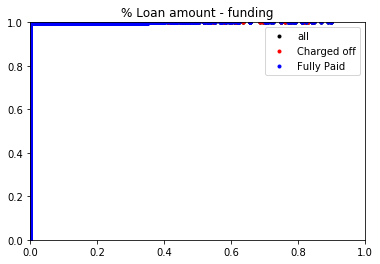

count    2.507640e+06
mean     4.698212e-04
std      1.294433e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.987500e-01
Name: difference_asked, dtype: float64
count    498120.000000
mean          0.000419
std           0.012315
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.845313
Name: difference_asked, dtype: float64
count    2.009520e+06
mean     4.824310e-04
std      1.309553e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.987500e-01
Name: difference_asked, dtype: float64


In [10]:
df_x,df_y = ecdf(df.difference_asked)
df_bad_x,df_bad_y = ecdf(df.loc[df.loan_status==0].difference_asked)
df_pass_x,df_pass_y = ecdf(df.loc[df.loan_status==1].difference_asked)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 1, 0, 1])
plt.title('% Loan amount - funding')
plt.legend(loc='best')
plt.show()

print(df.difference_asked.describe())
print(df.loc[df.loan_status==0].difference_asked.describe())
print(df.loc[df.loan_status==1].difference_asked.describe())

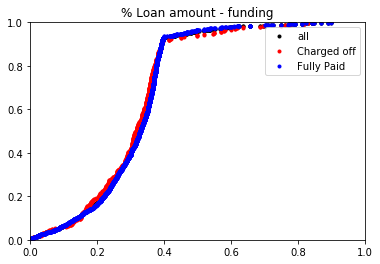

count    3842.000000
mean        0.306648
std         0.124407
min         0.000909
25%         0.242308
50%         0.327083
75%         0.371000
max         0.898750
Name: difference_asked, dtype: float64
count    684.000000
mean       0.305099
std        0.132364
min        0.005000
25%        0.229130
50%        0.316609
75%        0.363000
max        0.845313
Name: difference_asked, dtype: float64
count    3158.000000
mean        0.306984
std         0.122635
min         0.000909
25%         0.243397
50%         0.329688
75%         0.371503
max         0.898750
Name: difference_asked, dtype: float64


In [11]:
percent_diff = df.loc[(df.difference_asked > 0) | (df.difference_asked < 0)]

df_x,df_y = ecdf(percent_diff.difference_asked)
df_bad_x,df_bad_y = ecdf(percent_diff.loc[percent_diff.loan_status==0].difference_asked)
df_pass_x,df_pass_y = ecdf(percent_diff.loc[percent_diff.loan_status==1].difference_asked)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 1, 0, 1])
plt.title('% Loan amount - funding')
plt.legend(loc='best')
plt.show()

print(percent_diff.difference_asked.describe())
print(percent_diff.loc[percent_diff.loan_status==0].difference_asked.describe())
print(percent_diff.loc[percent_diff.loan_status==1].difference_asked.describe())

Everyone basically gets their loan funded but the ones that don't get at least 40% of their loans funded

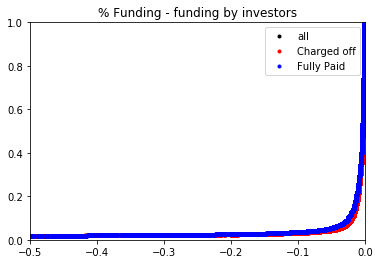

count    2.197920e+05
mean             -inf
std               NaN
min              -inf
25%     -9.372747e-03
50%     -3.764115e-03
75%     -1.890359e-03
max     -1.514523e-05
Name: difference_inv, dtype: float64
count    4.602200e+04
mean             -inf
std               NaN
min              -inf
25%     -8.403361e-03
50%     -3.344482e-03
75%     -1.669449e-03
max     -2.471847e-05
Name: difference_inv, dtype: float64
count    1.737700e+05
mean             -inf
std               NaN
min              -inf
25%     -1.010101e-02
50%     -3.921569e-03
75%     -2.004008e-03
max     -1.514523e-05
Name: difference_inv, dtype: float64


In [12]:
percent_diff = df.loc[(df.difference_inv > 0) | (df.difference_inv < 0)]

df_x,df_y = ecdf(percent_diff.difference_inv)
df_bad_x,df_bad_y = ecdf(percent_diff.loc[percent_diff.loan_status==0].difference_inv)
df_pass_x,df_pass_y = ecdf(percent_diff.loc[percent_diff.loan_status==1].difference_inv)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([-.5, 0, 0, 1])
plt.title('% Funding - funding by investors')
plt.legend(loc='best')
plt.show()

print(percent_diff.difference_inv.describe())
print(percent_diff.loc[percent_diff.loan_status==0].difference_inv.describe())
print(percent_diff.loc[percent_diff.loan_status==1].difference_inv.describe())


There is little difference between the loan amount, the funded, and the proportion funded by investors.

In [13]:
for thing in df.columns:
    print(thing,df[thing].dtypes)

id int64
member_id float64
loan_amnt float64
funded_amnt float64
funded_amnt_inv float64
term int64
int_rate float64
installment float64
grade object
sub_grade object
emp_title object
emp_length object
home_ownership object
annual_inc float64
verification_status object
issue_d datetime64[ns]
loan_status int64
pymnt_plan object
url object
desc object
purpose object
title object
zip_code object
addr_state object
dti float64
delinq_2yrs float64
earliest_cr_line datetime64[ns]
fico_range_low float64
fico_range_high float64
inq_last_6mths float64
mths_since_last_delinq float64
mths_since_last_record float64
open_acc float64
pub_rec float64
revol_bal float64
revol_util object
total_acc float64
initial_list_status object
out_prncp float64
out_prncp_inv float64
total_pymnt float64
total_pymnt_inv float64
total_rec_prncp float64
total_rec_int float64
total_rec_late_fee float64
recoveries float64
collection_recovery_fee float64
last_pymnt_d object
last_pymnt_amnt float64
next_pymnt_d float64
las

In [14]:
percentage(df,df_bad,'grade')

   n_samples    percent
A     434114   5.989210
B     731908  13.260137
C     711534  22.216507
D     374050  30.109344
E     177466  38.392706
F      61314  45.046808
G      17254  49.913064


In [15]:
percentage(df,df_bad,'disbursement_method')

print(len(df_bad)/len(df))

q = df.loc[df.disbursement_method == 'Cash']['loan_status']

stats.ttest_1samp(q,len(df_pass)/len(df))

           n_samples    percent
Cash         2498216  19.856410
DirectPay       9424  21.901528
0.19864095324687756


Ttest_1sampResult(statistic=0.30452202511554294, pvalue=0.7607302407799575)

In [16]:
percentage(df,df_bad,'pub_rec_bankruptcies')

      n_samples     percent
0.0     2195318   19.491481
1.0      291904   22.368998
2.0       14856   24.771136
3.0        3012   22.841965
4.0         744   27.688172
5.0         266   24.060150
6.0          90   33.333333
7.0          30   26.666667
8.0          18   44.444444
9.0           4   50.000000
11.0          2  100.000000
12.0          2    0.000000


In [17]:
percentage(df,df_bad,'term')

    n_samples    percent
36    1904562  15.911480
60     603078  32.346728


In [18]:
df.pub_rec_bankruptcies.value_counts().sort_index()

0.0     2195318
1.0      291904
2.0       14856
3.0        3012
4.0         744
5.0         266
6.0          90
7.0          30
8.0          18
9.0           4
11.0          2
12.0          2
Name: pub_rec_bankruptcies, dtype: int64

In [19]:
print(len(df_pass)/len(df))

for n in range(13):
    q = df.loc[df.pub_rec_bankruptcies > n]['loan_status']
    print(n,np.mean(q),stats.ttest_1samp(q,len(df_pass)/len(df)))

0.8013590467531224
0 0.7749189522976381 Ttest_1sampResult(statistic=-35.3016183361352, pvalue=1.9306831281258704e-272)
1 0.7535744322960471 Ttest_1sampResult(statistic=-15.294019158451372, pvalue=1.720678204181511e-52)
2 0.7581573896353166 Ttest_1sampResult(statistic=-6.512774762957765, pvalue=8.25370462174509e-11)
3 0.7231833910034602 Ttest_1sampResult(statistic=-5.938027864030991, pvalue=3.811556938081145e-09)
4 0.7233009708737864 Ttest_1sampResult(statistic=-3.5373286455001787, pvalue=0.00045028370651973285)
5 0.6575342465753424 Ttest_1sampResult(statistic=-3.6496399135071913, pvalue=0.0003657339433507724)
6 0.6428571428571429 Ttest_1sampResult(statistic=-2.453226270973029, pvalue=0.01735593601309045)
7 0.5384615384615384 Ttest_1sampResult(statistic=-2.6367878046950852, pvalue=0.01418037686703649)
8 0.5 Ttest_1sampResult(statistic=-1.5946421860964979, pvalue=0.15482181803309875)
9 0.5 Ttest_1sampResult(statistic=-1.0439383605938655, pvalue=0.3732299812766604)
10 0.5 Ttest_1sampResul

C:\Users\leero\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\leero\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\leero\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\leero\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\leero\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\leero\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\leero\Anaconda3\lib\

In [20]:
percentage(df,df_bad,'verification_status')

                 n_samples    percent
Not Verified        749220  14.468647
Source Verified     969034  20.935282
Verified            789386  23.670042


Somehow it is safer to loan to people whose income wasn't verified.

In [21]:
percentage(df.loc[df.verification_status!='Not Verified'],df_bad.loc[df_bad.verification_status!='Not Verified'],'grade')

   n_samples    percent
A     235730   6.510839
B     473476  13.971564
C     526972  23.120014
D     295522  31.153687
E     154562  39.232153
F      55898  45.654585
G      16260  50.172202


In [23]:
percentage(df.loc[df.verification_status=='Not Verified'],df_bad.loc[(df_bad.verification_status=='Not Verified')],'grade')

   n_samples    percent
A     198384   5.369385
B     258432  11.956724
C     184562  19.636762
D      78528  26.179197
E      22904  32.727908
F       5416  38.774003
G        994  45.674044


WOW IT IS!

In [26]:
percentage(df,df_bad,'home_ownership')

for thing in df.home_ownership.value_counts().sort_index().index.tolist():
    print(thing,stats.ttest_1samp(df.loc[df.home_ownership==thing]['loan_status'],len(df_pass)/len(df)))

          n_samples    percent
ANY             518  19.305019
MORTGAGE    1242936  17.133947
NONE             96  14.583333
OTHER           288  18.750000
OWN          266898  20.517201
RENT         996904  23.094300
ANY Ttest_1sampResult(statistic=0.3220755484142699, pvalue=0.7475256499097085)
MORTGAGE Ttest_1sampResult(statistic=80.77804781573754, pvalue=0.0)
NONE Ttest_1sampResult(statistic=1.4583396560222688, pvalue=0.14804517570683082)
OTHER Ttest_1sampResult(statistic=0.48356067954584586, pvalue=0.6290664068190173)
OWN Ttest_1sampResult(statistic=-8.355258414165064, pvalue=6.55968199052472e-17)
RENT Ttest_1sampResult(statistic=-76.52878537793073, pvalue=0.0)


Will delete these low sample items, I am not even sure what kind of mortgage is "Any", "None", or "Other"

In [27]:
percentage(df,df_bad,'grade')

   n_samples    percent
A     434114   5.989210
B     731908  13.260137
C     711534  22.216507
D     374050  30.109344
E     177466  38.392706
F      61314  45.046808
G      17254  49.913064


In [28]:
percentage(df,df_bad,'sub_grade')

    n_samples    percent
A1      79660   3.218679
A2      68442   4.631659
A3      69396   5.481584
A4      97030   6.742245
A5     119586   8.295285
B1     131774  10.266062
B2     137888  11.251160
B3     153242  12.862009
B4     156188  14.705355
B5     152816  16.576798
C1     159434  18.791475
C2     148146  20.579698
C3     140024  22.303319
C4     138548  24.688916
C5     125382  25.676732
D1      96310  27.646143
D2      83326  29.268176
D3      72988  30.172083
D4      66020  32.247804
D5      55406  33.025304
E1      45432  36.084698
E2      40602  37.549874
E3      34722  38.672888
E4      29760  40.080645
E5      26950  41.328386
F1      18972  42.040902
F2      13834  45.294203
F3      11694  44.894818
F4       9324  47.683398
F5       7490  49.158879
G1       5526  48.172277
G2       4114  49.052018
G3       3102  51.321728
G4       2410  50.705394
G5       2102  53.187441


In [29]:
percentage(df,df_bad,'verification_status_joint')

                 n_samples    percent
Not Verified         22572  21.664009
Source Verified       7894  23.030149
Verified              5834  25.917038


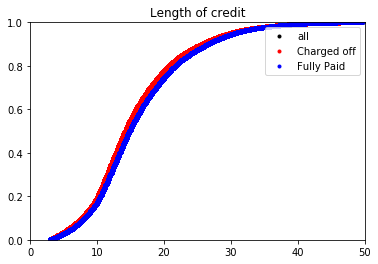

count    2.507640e+06
mean     1.602440e+01
std      7.998902e+00
min     -6.004110e+01
25%      1.117534e+01
50%      1.475616e+01
75%      1.993151e+01
max      4.970137e+01
Name: length_of_cr, dtype: float64
count    498120.000000
mean         15.445255
std           8.078662
min         -58.709589
25%          10.838356
50%          14.178082
75%          19.183562
max          49.117808
Name: length_of_cr, dtype: float64
count    2.009520e+06
mean     1.616796e+01
std      7.972506e+00
min     -6.004110e+01
25%      1.126027e+01
50%      1.484384e+01
75%      2.009863e+01
max      4.970137e+01
Name: length_of_cr, dtype: float64


In [30]:
df_x,df_y = ecdf(df.length_of_cr)
df_bad_x,df_bad_y = ecdf(df_bad.length_of_cr)
df_pass_x,df_pass_y = ecdf(df_pass.length_of_cr)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 50, 0, 1])
plt.title('Length of credit')
plt.legend(loc='best')
plt.show()

print(df.length_of_cr.describe())
print(df_bad.length_of_cr.describe())
print(df_pass.length_of_cr.describe())


In [31]:
percentage(df,df_pass,'emp_length')

for thing in df.emp_length.value_counts().sort_index().index.tolist():
    print(thing,stats.ttest_1samp(df.loc[df.emp_length==thing]['loan_status'],len(df_pass)/len(df)))

           n_samples    percent
1 year        164812  79.530617
10+ years     824588  81.274770
2 years       226758  80.266187
3 years       200576  80.089343
4 years       150192  80.298551
5 years       157126  80.488271
6 years       117608  80.751309
7 years       112658  80.557084
8 years       115110  80.118148
9 years        95802  80.123588
< 1 year      199366  79.663533
1 year Ttest_1sampResult(statistic=-6.0902565475575265, pvalue=1.129779246201112e-09)
10+ years Ttest_1sampResult(statistic=26.50935345715457, pvalue=8.785825766331608e-155)
2 years Ttest_1sampResult(statistic=1.5588113605122256, pvalue=0.11904243012481995)
3 years Ttest_1sampResult(statistic=-0.5222034035708175, pvalue=0.6015292932104181)
4 years Ttest_1sampResult(statistic=1.5847609925570736, pvalue=0.11302275354962361)
5 years Ttest_1sampResult(statistic=3.524538988044876, pvalue=0.00042434091868409)
6 years Ttest_1sampResult(statistic=5.353059299322614, pvalue=8.664095798806202e-08)
7 years Ttest_1sampRes

In [32]:
import itertools
for emp_len1, emp_len2 in itertools.permutations(df.emp_length.value_counts().sort_index().index.tolist(),2):
    print(emp_len1,emp_len2,stats.ttest_1samp(df.loc[df.emp_length==emp_len1]['loan_status'],np.mean(df.loc[df.emp_length==emp_len2]['loan_status'])))

1 year 10+ years Ttest_1sampResult(statistic=-17.54923472544548, pvalue=6.966809172544858e-69)
1 year 2 years Ttest_1sampResult(statistic=-7.4011233815056165, pvalue=1.356754216406228e-13)
1 year 3 years Ttest_1sampResult(statistic=-5.621761500254535, pvalue=1.893245908475725e-08)
1 year 4 years Ttest_1sampResult(statistic=-7.726765172313763, pvalue=1.1093173113161582e-14)
1 year 5 years Ttest_1sampResult(statistic=-9.635674155260396, pvalue=5.727945444501161e-22)
1 year 6 years Ttest_1sampResult(statistic=-12.282305679276645, pvalue=1.1674927004854931e-34)
1 year 7 years Ttest_1sampResult(statistic=-10.328060563078918, pvalue=5.35464019163651e-25)
1 year 8 years Ttest_1sampResult(statistic=-5.911591888229744, pvalue=3.3948090458438276e-09)
1 year 9 years Ttest_1sampResult(statistic=-5.966331588972595, pvalue=2.4313966658974166e-09)
1 year < 1 year Ttest_1sampResult(statistic=-1.3373746516674976, pvalue=0.18110221996501655)
10+ years 1 year Ttest_1sampResult(statistic=40.59863445216469

8 years 9 years Ttest_1sampResult(statistic=-0.04624764748877448, pvalue=0.9631129461010315)
8 years < 1 year Ttest_1sampResult(statistic=3.8645952283769525, pvalue=0.00011133455321026116)
9 years 1 year Ttest_1sampResult(statistic=4.599066367733433, pvalue=4.249303599595475e-06)
9 years 10+ years Ttest_1sampResult(statistic=-8.928524917073833, pvalue=4.391236282967955e-19)
9 years 2 years Ttest_1sampResult(statistic=-1.1059899335690255, pvalue=0.2687336537618484)
9 years 3 years Ttest_1sampResult(statistic=0.2656072131959807, pvalue=0.7905423012907054)
9 years 4 years Ttest_1sampResult(statistic=-1.3570065231937618, pvalue=0.1747823349902747)
9 years 5 years Ttest_1sampResult(statistic=-2.828463308927971, pvalue=0.004678176982406865)
9 years 6 years Ttest_1sampResult(statistic=-4.868583581891587, pvalue=1.1257957809525225e-06)
9 years 7 years Ttest_1sampResult(statistic=-3.362180048299185, pvalue=0.000773599216788433)
9 years 8 years Ttest_1sampResult(statistic=0.04219536123864575, pv

In [33]:
print(stats.ttest_1samp(df.loc[df.emp_length=='< 1 year']['loan_status'],np.mean(df.loc[df.emp_length=='1 year']['loan_status'])))
stats.ttest_1samp(df.loc[df.emp_length=='1 year']['loan_status'],np.mean(df.loc[df.emp_length=='< 1 year']['loan_status']))

Ttest_1sampResult(statistic=1.4744718020012868, pvalue=0.14035618350156837)


Ttest_1sampResult(statistic=-1.3373746516674976, pvalue=0.18110221996501655)

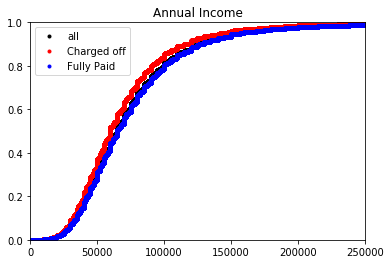

count    2.507640e+06
mean     7.609940e+04
std      6.969604e+04
min      0.000000e+00
25%      4.594575e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64
count    4.981200e+05
mean     7.024296e+04
std      6.568454e+04
min      0.000000e+00
25%      4.300000e+04
50%      6.000000e+04
75%      8.500000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64
count    2.009520e+06
mean     7.755109e+04
std      7.058010e+04
min      0.000000e+00
25%      4.700000e+04
50%      6.500000e+04
75%      9.270000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64


In [34]:
df_x,df_y = ecdf(df.annual_inc)
df_bad_x,df_bad_y = ecdf(df_bad.annual_inc)
df_pass_x,df_pass_y = ecdf(df_pass.annual_inc)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 250000, 0, 1])
plt.title('Annual Income')
plt.legend(loc='best')
plt.show()

print(df.annual_inc.describe())
print(df_bad.annual_inc.describe())
print(df_pass.annual_inc.describe())

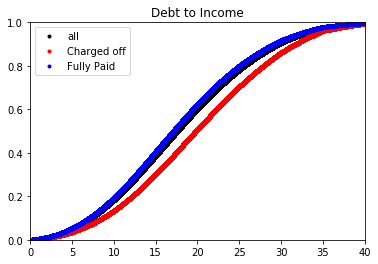

count    2.507172e+06
mean     1.822313e+01
std      1.051788e+01
min     -1.000000e+00
25%      1.181000e+01
50%      1.761000e+01
75%      2.401000e+01
max      9.990000e+02
Name: dti, dtype: float64
count    498034.000000
mean         20.132151
std          10.537612
min           0.000000
25%          13.630000
50%          19.800000
75%          26.310000
max         999.000000
Name: dti, dtype: float64
count    2.009138e+06
mean     1.774991e+01
std      1.045924e+01
min     -1.000000e+00
25%      1.143000e+01
50%      1.709000e+01
75%      2.339000e+01
max      9.990000e+02
Name: dti, dtype: float64


In [35]:
df_x,df_y = ecdf(df.dti)
df_bad_x,df_bad_y = ecdf(df_bad.dti)
df_pass_x,df_pass_y = ecdf(df_pass.dti)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 40, 0, 1])
plt.title('Debt to Income')
plt.legend(loc='best')
plt.show()

print(df.dti.describe())
print(df_bad.dti.describe())
print(df_pass.dti.describe())

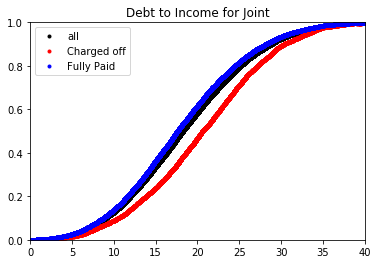

count    36552.000000
mean        18.686105
std          7.573205
min          0.000000
25%         13.217500
50%         18.265000
75%         23.832500
max         69.490000
Name: dti_joint, dtype: float64
count    8248.000000
mean       20.652650
std         7.692684
min         0.770000
25%        15.340000
50%        20.600000
75%        25.830000
max        69.490000
Name: dti_joint, dtype: float64
count    28304.000000
mean        18.113038
std          7.441006
min          0.000000
25%         12.770000
50%         17.590000
75%         23.070000
max         61.900000
Name: dti_joint, dtype: float64


In [36]:
df_x,df_y = ecdf(df.dti_joint.dropna())
df_bad_x,df_bad_y = ecdf(df_bad.dti_joint.dropna())
df_pass_x,df_pass_y = ecdf(df_pass.dti_joint.dropna())

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 40, 0, 1])
plt.title('Debt to Income for Joint')
plt.legend(loc='best')
plt.show()

print(df.dti_joint.describe())
print(df_bad.dti_joint.describe())
print(df_pass.dti_joint.describe())

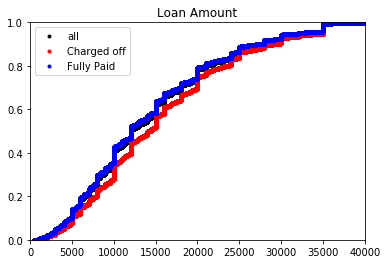

count    2.507640e+06
mean     1.441101e+04
std      8.663254e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64
count    498120.000000
mean      15507.632097
std        8743.623101
min         900.000000
25%        9000.000000
50%       14250.000000
75%       20200.000000
max       40000.000000
Name: loan_amnt, dtype: float64
count    2.009520e+06
mean     1.413918e+04
std      8.621673e+03
min      5.000000e+02
25%      7.500000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64


In [37]:
df_x,df_y = ecdf(df.loan_amnt)
df_bad_x,df_bad_y = ecdf(df_bad.loan_amnt)
df_pass_x,df_pass_y = ecdf(df_pass.loan_amnt)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 40000, 0, 1])
plt.title('Loan Amount')
plt.legend(loc='best')
plt.show()

print(df.loan_amnt.describe())
print(df_bad.loan_amnt.describe())
print(df_pass.loan_amnt.describe())

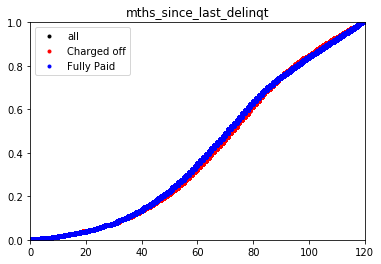

count    426228.000000
mean         70.417044
std          26.664615
min           0.000000
25%          53.000000
50%          71.000000
75%          90.000000
max         129.000000
Name: mths_since_last_record, dtype: float64
count    96542.000000
mean        70.763875
std         26.407839
min          0.000000
25%         53.000000
50%         72.000000
75%         90.000000
max        129.000000
Name: mths_since_last_record, dtype: float64
count    329686.000000
mean         70.315482
std          26.738528
min           0.000000
25%          52.000000
50%          71.000000
75%          90.000000
max         123.000000
Name: mths_since_last_record, dtype: float64


In [38]:
df_x,df_y = ecdf(df.mths_since_last_record.dropna())
df_bad_x,df_bad_y = ecdf(df_bad.mths_since_last_record.dropna())
df_pass_x,df_pass_y = ecdf(df_pass.mths_since_last_record.dropna())

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 120, 0, 1])
plt.title('mths_since_last_delinqt')
plt.legend(loc='best')
plt.show()

print(df.mths_since_last_record.describe())
print(df_bad.mths_since_last_record.describe())
print(df_pass.mths_since_last_record.describe())


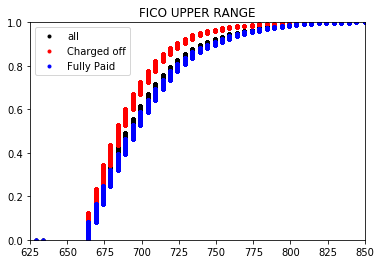

count    2.507640e+06
mean     6.998591e+02
std      3.161493e+01
min      6.290000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64
count    498120.000000
mean        691.429563
std          25.552005
min         664.000000
25%         674.000000
50%         684.000000
75%         704.000000
max         850.000000
Name: fico_range_high, dtype: float64
count    2.009520e+06
mean     7.019486e+02
std      3.261042e+01
min      6.290000e+02
25%      6.790000e+02
50%      6.940000e+02
75%      7.190000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64


In [39]:
df_x,df_y = ecdf(df.fico_range_high)
df_bad_x,df_bad_y = ecdf(df_bad.fico_range_high)
df_pass_x,df_pass_y = ecdf(df_pass.fico_range_high)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([625, 850, 0, 1])
plt.title('FICO UPPER RANGE')
plt.legend(loc='best')
plt.show()

print(df.fico_range_high.describe())
print(df_bad.fico_range_high.describe())
print(df_pass.fico_range_high.describe())

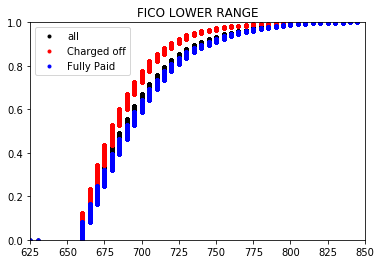

count    2.507640e+06
mean     6.958590e+02
std      3.161433e+01
min      6.250000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.100000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64
count    498120.000000
mean        687.429515
std          25.551707
min         660.000000
25%         670.000000
50%         680.000000
75%         700.000000
max         845.000000
Name: fico_range_low, dtype: float64
count    2.009520e+06
mean     6.979485e+02
std      3.260976e+01
min      6.250000e+02
25%      6.750000e+02
50%      6.900000e+02
75%      7.150000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64


In [40]:
df_x,df_y = ecdf(df.fico_range_low)
df_bad_x,df_bad_y = ecdf(df_bad.fico_range_low)
df_pass_x,df_pass_y = ecdf(df_pass.fico_range_low)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([625, 850, 0, 1])
plt.title('FICO LOWER RANGE')
plt.legend(loc='best')
plt.show()

print(df.fico_range_low.describe())
print(df_bad.fico_range_low.describe())
print(df_pass.fico_range_low.describe())

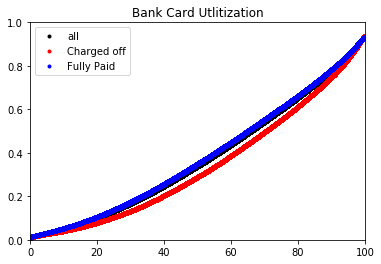

count    2.386342e+06
mean     6.044169e+01
std      2.812853e+01
min      0.000000e+00
25%      3.900000e+01
50%      6.380000e+01
75%      8.510000e+01
max      3.396000e+02
Name: bc_util, dtype: float64
count    478756.000000
mean         64.283428
std          27.382505
min           0.000000
25%          44.600000
50%          68.800000
75%          88.300000
max         255.200000
Name: bc_util, dtype: float64
count    1.907586e+06
mean     5.947751e+01
std      2.823074e+01
min      0.000000e+00
25%      3.780000e+01
50%      6.250000e+01
75%      8.430000e+01
max      3.396000e+02
Name: bc_util, dtype: float64


In [41]:
df_x,df_y = ecdf(df.bc_util)
df_bad_x,df_bad_y = ecdf(df_bad.bc_util)
df_pass_x,df_pass_y = ecdf(df_pass.bc_util)

plt.plot(df_x,df_y,marker='.',linestyle='none',color='black',label='all')
plt.plot(df_bad_x,df_bad_y,marker='.',linestyle='none',color='red',label='Charged off')
plt.plot(df_pass_x,df_pass_y,marker='.',linestyle='none',color='blue',label='Fully Paid')
plt.axis([0, 100, 0, 1])
plt.title('Bank Card Utlitization')
plt.legend(loc='best')
plt.show()

print(df.bc_util.describe())
print(df_bad.bc_util.describe())
print(df_pass.bc_util.describe())

# About the graphs and the EDA

The graphs show and the whole exploratory data analysis so far has shown obvious things. With factors that are desirable the good loans out performed the bad loans. Although good loans do look very close to the population while, the bad loans do seem to significantly deviate from the norm. 

In [42]:
df_bad.tot_coll_amt.describe()

count    477484.000000
mean        237.522505
std        1752.307548
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      146917.000000
Name: tot_coll_amt, dtype: float64

In [43]:
percentage(df,df_bad,'chargeoff_within_12_mths')
 

      n_samples    percent
0.0     2487386  19.852970
1.0       18312  21.472259
2.0        1434  17.852162
3.0         236  23.728814
4.0          88  34.090909
5.0          34  17.647059
6.0          14  28.571429
7.0          12  16.666667
8.0           4  50.000000
9.0           6   0.000000
10.0          2   0.000000


In [44]:
percentage(df,df_bad,'policy_code')

     n_samples    percent
1.0    2507640  19.864095


In [45]:
percentage(df,df_bad,'purpose')

print(len(df_bad)/len(df))

for thing in df.purpose.value_counts().sort_index().index.tolist():
    print(thing,stats.ttest_1samp(df.loc[df.purpose==thing]['loan_status'],len(df_pass)/len(df)))

                    n_samples    percent
car                     27082  14.400709
credit_card            551450  16.858827
debt_consolidation    1461114  21.066255
educational               652  17.177914
home_improvement       161660  17.622170
house                   12736  21.278266
major_purchase          54082  18.165009
medical                 28352  21.621050
moving                  17616  23.206176
other                  141124  20.924860
renewable_energy         1744  23.279817
small_business          28818  29.308071
vacation                16622  18.998917
wedding                  4588  12.162162
0.19864095324687756
car Ttest_1sampResult(statistic=25.607503613543102, pvalue=6.33407905942162e-143)
credit_card Ttest_1sampResult(statistic=59.609327438524716, pvalue=0.0)
debt_consolidation Ttest_1sampResult(statistic=-35.635184341815275, pvalue=5.26852813749487e-278)
educational Ttest_1sampResult(statistic=1.8170526287938882, pvalue=0.06966870982546704)
home_improvement Ttest_1s

The first statistically not so important factor! Although this maybe because of its small sample size relative to everything else.

In [46]:
for col in df:
    print(col,df[col].dtypes,df[col].isnull().values.any())

id int64 False
member_id float64 True
loan_amnt float64 False
funded_amnt float64 False
funded_amnt_inv float64 False
term int64 False
int_rate float64 False
installment float64 False
grade object False
sub_grade object False
emp_title object True
emp_length object True
home_ownership object False
annual_inc float64 False
verification_status object False
issue_d datetime64[ns] False
loan_status int64 False
pymnt_plan object False
url object False
desc object True
purpose object False
title object True
zip_code object False
addr_state object False
dti float64 True
delinq_2yrs float64 False
earliest_cr_line datetime64[ns] False
fico_range_low float64 False
fico_range_high float64 False
inq_last_6mths float64 True
mths_since_last_delinq float64 True
mths_since_last_record float64 True
open_acc float64 False
pub_rec float64 False
revol_bal float64 False
revol_util object True
total_acc float64 False
initial_list_status object False
out_prncp float64 False
out_prncp_inv float64 False
total_

In [47]:
# dropping not so important stuff, variables that appear in the future,things of interest

drop_list = ['member_id', 'url', 'desc', 'emp_title', 'title', 'addr_state', 'next_pymnt_d', 'last_pymnt_amnt',
             'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_amount',
             'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length',
             'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
             'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag', 'orig_projected_additional_accrued_interest',
             'out_prncp_inv', 'out_prncp', 'recoveries', 'last_fico_range_high', 'last_fico_range_low',
             'policy_code', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
             'difference_inv', 'difference_asked','diff_fico_high','diff_fico_low'
             ]
df.dropna(subset=['id'], inplace=True)
df.drop((df.loc[(df.home_ownership == 'ANY') | (df.home_ownership == 'NONE') | (df.home_ownership == 'OTHER')]).index, inplace=True)
df.drop(drop_list, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506738 entries, 0 to 2507639
Columns: 118 entries, id to length_of_cr
dtypes: datetime64[ns](2), float64(94), int64(3), object(19)
memory usage: 2.2+ GB
